# 에러 분석

에러 분석을 구현하기 위해서는, 데이터가 있어야 할 것 같아서 MNIST fashion data를 이용해 책과 똑같이 진행하였습니다.

## - 데이터 셋팅

MNIST fasion data 형태

0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

<img src ="https://www.pyimagesearch.com/wp-content/uploads/2019/02/fashion_mnist_results.jpg">

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# warning 메세지 제거

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
# fetch_openml() returns targets as strings

from sklearn.datasets import fetch_openml
mnist = fetch_openml('Fashion-MNIST', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) 
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([9, 0, 0, ..., 8, 1, 5], dtype=int8))

In [4]:
mnist.data.shape

(70000, 784)

In [5]:
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

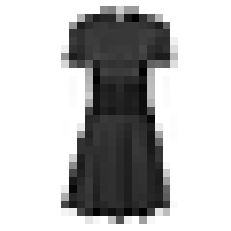

3

In [6]:
item = X[36030]
item_image = item.reshape(28, 28)
plt.imshow(item_image, cmap = plt.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()
y[36030]

## - 데이터 셋 분할

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## - 이진 분류기 훈련 (3만 구분)

In [8]:
y_train_3 = (y_train == 3)
y_test_3 = (y_test == 3)

print('X_train.shape :', X_train.shape)
print('X_test.shape :', X_test.shape)
print('y_train.shape :', y_train.shape)
print('y_test.shape :', y_test.shape)

X_train.shape : (60000, 784)
X_test.shape : (10000, 784)
y_train.shape : (60000,)
y_test.shape : (10000,)


In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=10)
sgd_clf.fit(X_train, y_train_3)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=10, shuffle=True, tol=-inf, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [10]:
sgd_clf.predict([item])

array([ True])

## - 교차 검증

In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_3, cv=3, scoring='accuracy')

array([0.954  , 0.95135, 0.9326 ])

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_3):
    clone_clf = clone(sgd_clf)  
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_3[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_3[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.954
0.95135
0.9326


In [13]:
from sklearn.base import BaseEstimator

class Never3Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [14]:
never_3_clf = Never3Classifier()
cross_val_score(never_3_clf, X_train, y_train_3, cv=3, scoring="accuracy")

array([0.89975, 0.90105, 0.8992 ])

## - 오차행렬

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3)
y_train_pred

array([False, False, False, ..., False, False, False])

## - 랜덤포레스트

In [16]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_3, cv=3,
                                    method="predict_proba")

## - 다중 분류

In [17]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=10, shuffle=True, tol=-inf, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [18]:
sgd_clf.predict([item])

array([3], dtype=int8)

In [19]:
item_scores = sgd_clf.decision_function([item])
item_scores

array([[-1007698.70583589,  -540011.3971905 , -1014424.59057271,
          357228.60938727,  -555956.51221427, -1895649.3933666 ,
           17302.97320417, -1167203.02794892, -1096934.83317716,
        -1189021.40443863]])

In [20]:
np.argmax(item_scores)

3

In [21]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False,
                                           class_weight=None,
                                           early_stopping=False, epsilon=0.1,
                                           eta0=0.0, fit_intercept=True,
                                           l1_ratio=0.15,
                                           learning_rate='optimal',
                                           loss='hinge', max_iter=5,
                                           n_iter_no_change=5, n_jobs=None,
                                           penalty='l2', power_t=0.5,
                                           random_state=42, shuffle=True,
                                           tol=0.001, validation_fraction=0.1,
                                           verbose=0, warm_start=False),
                   n_jobs=None)

In [22]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8362, 0.8361, 0.8346])

## - 에러 분석

원칙적으로는
- 데이터 준비 단계에서 가능한 선택사항을 탐색하고,
- 여러 모델을 시도하고,
- 가장 좋은 몇 개를 골라 GridSearchCV를 사용해 하이퍼파라미터를 세밀하게 튜닝하고,
- 파이프라인을 통해 가능한 자동화해야합니다.

하지만 책에서는 가능성이 높은 모델을 찾았다고 가정하고 합니다.

### 1. 에러의 종류 분석

먼저, 오차 행렬을 살펴볼 수 있습니다. 오차 행렬은 분류기의 성능을 보여줍니다.

cross_val_predict() 함수를 사용해 예측을 만들고, confusion_matrix() 함수를 호출합니다.

croww_val_predict() 함수는 K-fold cross-validation을 수행합니다. 

그러나 evaluation scores를 반환하는 것이 아니라, 각각의 예측 값을 반환하게 됩니다.

오차 행렬의 장점은 해석이 용이하다는 것입니다.

In [24]:
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[4764,   40,  120,  480,   25,    3,  465,    0,  103,    0],
       [   7, 5749,   54,  143,   18,    1,   25,    0,    3,    0],
       [  48,   10, 4571,  116,  725,    1,  436,    1,   91,    1],
       [ 173,  106,   77, 5226,  240,    0,  163,    0,   14,    1],
       [   8,    6,  714,  269, 4443,    1,  528,    1,   29,    1],
       [   3,    4,    2,    8,    0, 5566,    2,  223,   79,  113],
       [ 796,   22,  776,  414,  540,    0, 3240,    3,  208,    1],
       [   0,    0,    0,    0,    0,  383,    0, 5298,   19,  300],
       [  21,    4,   29,  109,   29,   13,   83,   27, 5678,    7],
       [   0,    4,    0,    3,    0,  132,    1,  253,    4, 5603]],
      dtype=int64)

오차행렬을 heatmap() 함수를 사용해 이미지로 표현하면 보기에 편리합니다. 

행은 실제 클래스를 표시하고, 열은 분류기의 예측 클래스를 표시합니다.

숫자가 클수록 올바르게 분류되었다는 뜻입니다. 

아래 그림에서 보면, 밝을수록 높은 값, 어두울수록 낮은 값을 나타냅니다.

이상적인 경우, 대각선은 모두 흰색(값이 존재), 나머지는 검정색(값이 0)이어야 합니다. 이는 모든 이미지가 올바르게 분류되었음을 나타냅니다. (정확도 100%)

그림에서는 6이 다른 숫자보다 어두워 보입니다. 이는 데이터셋에 6의 이미지가 적거나 분류기가 6을 다른 것들만큼 잘 분류하지 못한다는 뜻입니다.

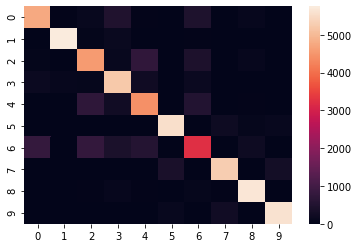

In [44]:
import seaborn as sns
sns.heatmap(conf_mx);

다음으로, 오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러의 비율을 비교합니다. 

에러의 절대 개수가 아니라 에러 비율을 비교합니다.

에러의 개수를 비교하면 이미지가 많은 클래스가 더 나쁘게 보이므로, 클래스의 개수로 나눠야 합니다.

In [26]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

### keepdims 예시

In [31]:
a = np.array([[1,2,3],[4,5,6],[7,8,9]]) ; a

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [29]:
# 2에서 1로 dim이 떨어짐

a.sum(axis=1)  

array([ 6, 15, 24])

In [30]:
# column을 유지하고, dim도 유지

a.sum(axis=1, keepdims=True)

array([[ 6],
       [15],
       [24]])

In [32]:
# row를 유지하고 dim도 유지

a.sum(axis= 0, keepdims= True)

array([[12, 15, 18]])

In [33]:
# dim 유지

a.sum(keepdims=True)

array([[45]])

다음으로, 주대각선만 0으로 채워서 그래프를 그립니다.

마찬가지로 행은 실제 클래스, 열은 예측한 클래스를 나타냅니다. 


밝기가 어두울수록 정확히 분류되고, 밝을수록 잘못 분류되었음을 뜻합니다. 

(cmap=plt.cm.gray로 설정을 주면, gray로 변경되어, 밝기를 더 잘 비교할 수 있습니다.)

1의 열은 매우 어두우므로 대부분의 1이 정확하게 분류되었음을 의미합니다.

클래스 6과 2의 열이 상당히 밝으므로, 많은 이미지가 6과 2로 잘못 분류되었음을 암시합니다.

또 반대로, 6과 2의 행도 밝으므로 6과 2가 혼돈이 자주 된다는 것을 알 수 있습니다.

여기서 유의할 점은 대각선을 기준으로 에러가 대칭이 아니라는 점입니다. 

6을 2로 잘못 분류한 경우와 2를 6으로 잘못 분류한 경우는 다른 경우이기 때문입니다.

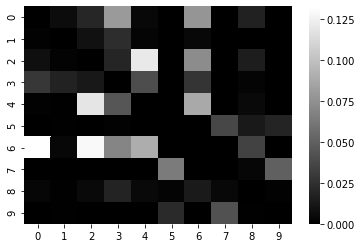

In [47]:
np.fill_diagonal(norm_conf_mx, 0)
sns.heatmap(norm_conf_mx, cmap=plt.cm.gray);

다음은 그림을 그리기 위한 셋팅입니다.

In [35]:
def plot_items(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]    
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

앞서서 분류기가 2와 6을 많이 헷갈려한다는 것을 알았기 때문에, 6과 2를 그려보겠습니다.

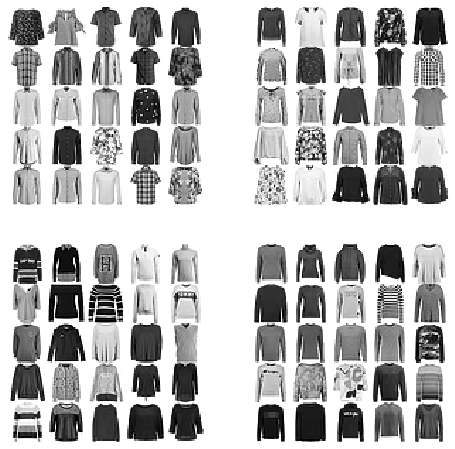

In [45]:
# 2는 pullover
# 6은 Shirt

cl_a, cl_b = 6, 2
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)] # 6으로 정확히 분류
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)] # 2로 잘못 분류
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)] # 6으로 잘못 분류
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)] # 2로 정확히 분류

plt.figure(figsize=(8,8))
plt.subplot(221); plot_items(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_items(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_items(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_items(X_bb[:25], images_per_row=5)
plt.show()

혼란을 줄이는 방법은 

- 이 숫자 데이터를 더 모으는 것입니다.
- 분류기에 도움이 될 특성을 더 찾아보는 것입니다.
- 이미지를 전처리하여, 이미지를 더 알아보기 쉽도록 하는 것입니다.